In [1]:
from tvDatafeed import TvDatafeed, Interval
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

Load Data

In [2]:
tv = TvDatafeed()
df = tv.get_hist(symbol='HKEX:700', exchange='HKEX', interval=Interval.in_daily, n_bars=1201)
hk50 = df[['close']]
hk50.rename(columns = {'close':'hk50'}, inplace=True)
hk50

you are using nologin method, data you access may be limited
C:\Users\Inv_edg\AppData\Local\Temp\ipykernel_24300\1553682231.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hk50.rename(columns = {'close':'hk50'}, inplace=True)


,hk50
datetime,
2019-06-17 08:30:00,303.290461
2019-06-18 08:30:00,307.899739
2019-06-19 08:30:00,320.068241
2019-06-20 08:30:00,326.336849
2019-06-21 08:30:00,326.705582
...,...
2024-04-23 08:30:00,332.399990
2024-04-24 08:30:00,344.200010
2024-04-25 08:30:00,339.399990


In [3]:
name = ['HKEX:700','HKEX:5','HKEX:9988','HKEX:1299','HKEX:3690','HKEX:939','HKEX:941','HKEX:1398','HKEX:883','HKEX:388','HKEX:3988','HKEX:1810','HKEX:2318','HKEX:1211','HKEX:9618','HKEX:2015','HKEX:669','HKEX:857','HKEX:2','HKEX:3968','HKEX:2020','HKEX:9999','HKEX:16','HKEX:386','HKEX:1088','HKEX:1','HKEX:823','HKEX:27','HKEX:2899','HKEX:9633','HKEX:1109','HKEX:2388','HKEX:992','HKEX:9888','HKEX:2628','HKEX:3','HKEX:11','HKEX:6','HKEX:981','HKEX:1113','HKEX:1928','HKEX:2313','HKEX:6690','HKEX:9961','HKEX:291','HKEX:175','HKEX:267','HKEX:1093','HKEX:2269','HKEX:2319']

#load all hk50 data
for i in range (len(name)):
    df = tv.get_hist(symbol=name[i], exchange='HKEX', interval=Interval.in_daily, n_bars=1201)
    df = df[['close']]
    hk50 = pd.merge(hk50, df, left_index=True, right_index=True, how='outer')
    hk50.rename(columns = {'close':name[i]}, inplace=True)
hk50 = hk50.drop('hk50',axis=1)

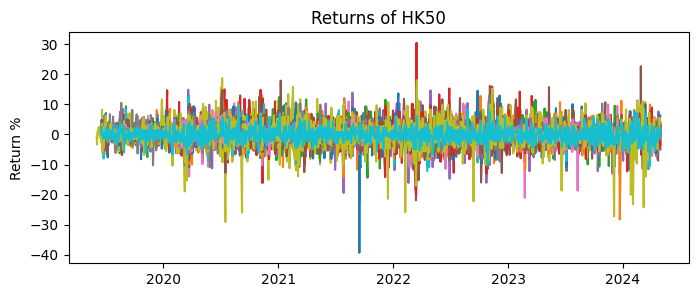

In [4]:
returns = np.log(hk50).diff() * 100 #1st difference
plt.figure(figsize=(8,3))
plt.plot(returns)
plt.ylabel("Return %")
plt.title('Returns of HK50');

Loop for the best model in each Stock

In [6]:
conclu = pd.DataFrame(name, columns=['HK50'])

In [7]:
from arch import arch_model
from sklearn.metrics import mean_squared_error
best_model_list = []
for i in range (len(name)):

    returns_individual = returns[[name[i]]]
    returns_individual = returns_individual.dropna()

    real_vol = []
    for i in range(len(returns)):
        vol = returns_individual[:i].std()
        real_vol.append(vol)

    len_test = int(0.2 * len(returns_individual))
    test_vol = real_vol[-len_test:]

    returns_train, returns_test= returns_individual[:-len_test], returns_individual[-len_test:]

    garch_model_fit = arch_model(returns_train,vol="Garch",p=1,q=1).fit(disp='off',update_freq=len(returns_test))
    arch_model_fit = arch_model(returns_train,vol="ARCH").fit(disp='off',update_freq=len(returns_test))
    gjr_garch_model_fit = arch_model(returns_train,p=1,o=1,q=1).fit(disp='off',update_freq=len(returns_test))
    harch_model_fit = arch_model(returns_train,vol='Harch').fit(disp='off',update_freq=len(returns_test))

    garch_forecast = garch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)
    arch_forecast = arch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)
    gjr_garch_forecast = gjr_garch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)
    harch_forecast = harch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)

    garch = garch_forecast.variance.values[-1,:].flatten()
    arch = arch_forecast.variance.values[-1,:].flatten()
    gjr = gjr_garch_forecast.variance.values[-1,:].flatten()
    harch = harch_forecast.variance.values[-1,:].flatten()

    df_test = returns_test.copy()
    df_test['garch']= np.sqrt(garch)
    df_test['arch']= np.sqrt(arch)
    df_test['gjr']= np.sqrt(gjr)
    df_test['harch']= np.sqrt(harch)
    df_test['Vol'] = np.array(test_vol)

    garch_mae = mean_squared_error(df_test['Vol'],df_test['garch'])
    arch_mae = mean_squared_error(df_test['Vol'],df_test['arch'])
    gjr_garch_mae = mean_squared_error(df_test['Vol'],df_test['gjr'])
    harch_mae = mean_squared_error(df_test['Vol'],df_test['harch'])
    mae = [garch_mae,arch_mae,gjr_garch_mae,harch_mae]
    best = mae.index(min(mae))

    if best == 0:
        mod = 'garch'
    elif best == 1:
        mod = 'arch'
    elif best == 2:
        mod = 'gjr'
    elif best == 3:
        mod = 'harch'
    best_model_list.append(mod)

conclu['Models'] = np.array(best_model_list)

Fit entire dataset with the best model of each stock

In [8]:
volatility_list = []
for i in range (len(name)):
    returns_individual = returns[[name[i]]].dropna()
    if conclu['Models'][i] == 'garch':
        forecast_model_fit = arch_model(returns_individual,vol="Garch", p=1,q=1).fit(disp='off')
    elif conclu['Models'][i] == 'arch':
        forecast_model_fit = arch_model(returns_individual,vol="ARCH").fit(disp='off')
    elif conclu['Models'][i] == 'gjr':
        forecast_model_fit = arch_model(returns_individual,p=1,o=1,q=1).fit(disp='off')
    elif conclu['Models'][i] == 'harch':
        forecast_model_fit = arch_model(returns_individual,vol="Harch").fit(disp='off')
    forecaste = forecast_model_fit.forecast(horizon=120,method='analytic',reindex=True)
    y = forecaste.variance.values[-1,:].flatten()
    df_y = pd.DataFrame(y)
    df_y.rename(columns={df_y.columns[0]:'forecast'},inplace=True)
    df_y['forecast'] = np.sqrt(df_y['forecast']) * sqrt(252)
    vol6m = float(df_y['forecast'].tail(1))
    volatility_list.append(vol6m)
conclu['Vol'] = np.array(volatility_list)

C:\Users\Inv_edg\AppData\Local\Temp\ipykernel_24300\2245444320.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vol6m = float(df_y['forecast'].tail(1))
C:\Users\Inv_edg\AppData\Local\Temp\ipykernel_24300\2245444320.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vol6m = float(df_y['forecast'].tail(1))
C:\Users\Inv_edg\AppData\Local\Temp\ipykernel_24300\2245444320.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vol6m = float(df_y['forecast'].tail(1))
C:\Users\Inv_edg\AppData\Local\Temp\ipykernel_24300\2245444320.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vol6m = float(df_y['

In [9]:
conclu

,HK50,Models,Vol
0,HKEX:700,arch,39.663322
1,HKEX:5,arch,26.599783
2,HKEX:9988,arch,49.407489
3,HKEX:1299,harch,32.306029
4,HKEX:3690,arch,59.763022
5,HKEX:939,arch,22.098069
6,HKEX:941,harch,24.064444
7,HKEX:1398,harch,22.882327
8,HKEX:883,harch,37.155021
9,HKEX:388,arch,32.540281
